### Team Info
Title: F1 Analysis

Team Name: Accelerated Analytics

Name: David Saffer

### Project Introduction
#### Description
We will use various F1 metrics, including telemetry, weather, and tyre data, to analyze driver and car performance throughout the season and over the years.

#### Research Questions
- Which tire compound do teams use as the race progresses

#### Data Source(s)
We will be using a prebuilt F1 data library called Fast F1: https://theoehrly.github.io/Fast-F1/.
This library includes F1 data updated to one year ago (2021), that being lap timing, car telemetry and position, tyre data, weather data, the event schedule and session results. If necessary, we will get geographical/geospatial circuit data from Open Elevation: https://open-elevation.com/.

### Question
#### Which tire compound do teams use as the race progresses
##### Motivation:
To better understand the strategy that Formula One teams use.

##### Methods:
Chart the compund each infividual uses for every lap.

### Analysis
#### Data
Date will come from the fastf1 api. Specificaly we will be looking at an indivdual race, but this notebook can easily be changed to any race. 

In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('./') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [3]:
#get race data from api
year = 2021
circut = "Nurburgring"

race = ff1.get_session(year, circut, "R")
laps = race.load_laps(with_telemetry = True)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']


In [4]:
#view laps data for understandind
laps.head()

,Time,DriverNumber,LapTime,LapNumber,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,Compound,TyreLife,FreshTyre,Stint,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate
0,0 days 00:39:09.688000,44,NaT,1.0,0 days 00:00:04.260000,NaT,NaT,0 days 00:00:54.367000,0 days 00:00:32.463000,NaT,...,MEDIUM,4.0,False,1,0 days 00:37:09.970000,Mercedes,HAM,24,False,2021-03-28 15:07:09.980
1,0 days 00:41:32.400000,44,0 days 00:02:22.712000,2.0,NaT,NaT,0 days 00:00:46.763000,0 days 00:01:01.387000,0 days 00:00:34.562000,0 days 00:39:56.451000,...,MEDIUM,5.0,False,1,0 days 00:39:09.688000,Mercedes,HAM,4,False,2021-03-28 15:09:09.698
2,0 days 00:44:09.058000,44,NaT,3.0,NaT,NaT,0 days 00:00:43.739000,0 days 00:01:02.116000,0 days 00:00:50.801000,0 days 00:42:16.144000,...,MEDIUM,6.0,False,1,0 days 00:41:32.400000,Mercedes,HAM,4,False,2021-03-28 15:11:32.410
3,0 days 00:45:53.990000,44,0 days 00:01:44.932000,4.0,NaT,NaT,0 days 00:00:32.339000,0 days 00:00:41.826000,0 days 00:00:30.767000,0 days 00:44:41.397000,...,MEDIUM,7.0,False,1,0 days 00:44:09.058000,Mercedes,HAM,26,False,2021-03-28 15:14:09.068
4,0 days 00:47:39.129000,44,0 days 00:01:45.139000,5.0,NaT,NaT,0 days 00:00:39.813000,0 days 00:00:41.410000,0 days 00:00:23.916000,0 days 00:46:33.803000,...,MEDIUM,8.0,False,1,0 days 00:45:53.990000,Mercedes,HAM,67,False,2021-03-28 15:15:54.000


In [5]:
#Extract relevant information
driver_stints = laps[['Driver', 'Stint', 'Compound', 'LapNumber']]
driver_stints = driver_stints.groupby(['Driver', 'Stint', 'Compound']).count()
driver_stints.head()

LapNumber
Driver Stint Compound           
ALO    1     SOFT             11
       2     MEDIUM           18
       3     HARD              3
BOT    1     MEDIUM           16
       2     HARD             14

In [6]:
#Convert to Data Frame
dS = pd.DataFrame(driver_stints).reset_index()
dS = dS.rename(columns ={'LapNumber': 'numLaps'})    

In [7]:
#define colors for plot
colors = {
    'SOFT': 'gray',
    'MEDIUM': 'green',
    'HARD': 'red',
    'INTERMEDIATE': 'purple',
    'WET': 'blue',
}

Legend
Soft = gray, Medium = green, Hard = red, Intermediate = purple, Wet = blue


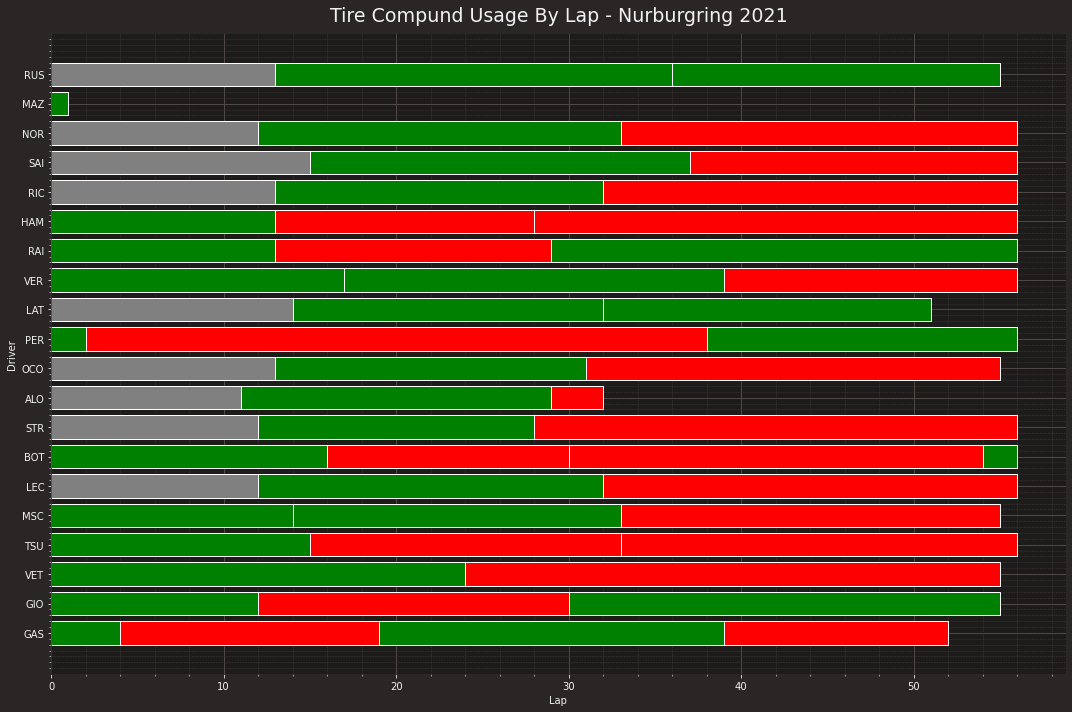

In [8]:
#Create plot
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
for driver in set(dS["Driver"]):
    stints = dS.loc[dS['Driver'] == driver]
    previous = 0
    for _, stint in stints.iterrows():        
        plt.barh(driver,
                 stint["numLaps"],
                 left=previous,
                 color=colors[stint["Compound"]],
                 edgecolor = "white")
        
        previous = previous + stint["numLaps"]

# Set title
plt.title(f'Tire Compund Usage By Lap - {circut} {year}')
        
# Set x-label
plt.xlabel("Lap")

# Set y-label
plt.ylabel("Driver")

#Legend does not display correctley....
#plt.legend(colors)
print("Legend")
print("Soft = gray, Medium = green, Hard = red, Intermediate = purple, Wet = blue")

### Conclusion
The analysis here shows which tire compound drivers uses throughout a race. Drivers are stacked on the y axis. The bar for each driver represents which compound they used as the race progressed. The x axis shows when each compound was used by lap number. The white lines inside each bar indicate the end/start of a stint. 


### Question
How does tire compound impact how fast a driver is able to complete a lap. 

#### Motivatin:
To understand the performance of each provides.
#### Methods:
Compare laptimes across different compounds.

### Analysis
#### Data
Data will come from the same F1 race as above.

In [9]:
#Extract relevant information
driver_stints = laps[['Driver', 'Stint', 'Compound', 'LapNumber','LapTime']]
driver_stints = driver_stints.groupby(['Driver', 'Stint', 'Compound']).count()
driver_stints.head()

LapNumber  LapTime
Driver Stint Compound                    
ALO    1     SOFT             11        9
       2     MEDIUM           18       18
       3     HARD              3        3
BOT    1     MEDIUM           16       14
       2     HARD             14       14

Text(0.5, 1.0, 'Median lap time compared to tire compound - Nurburgring 2021')

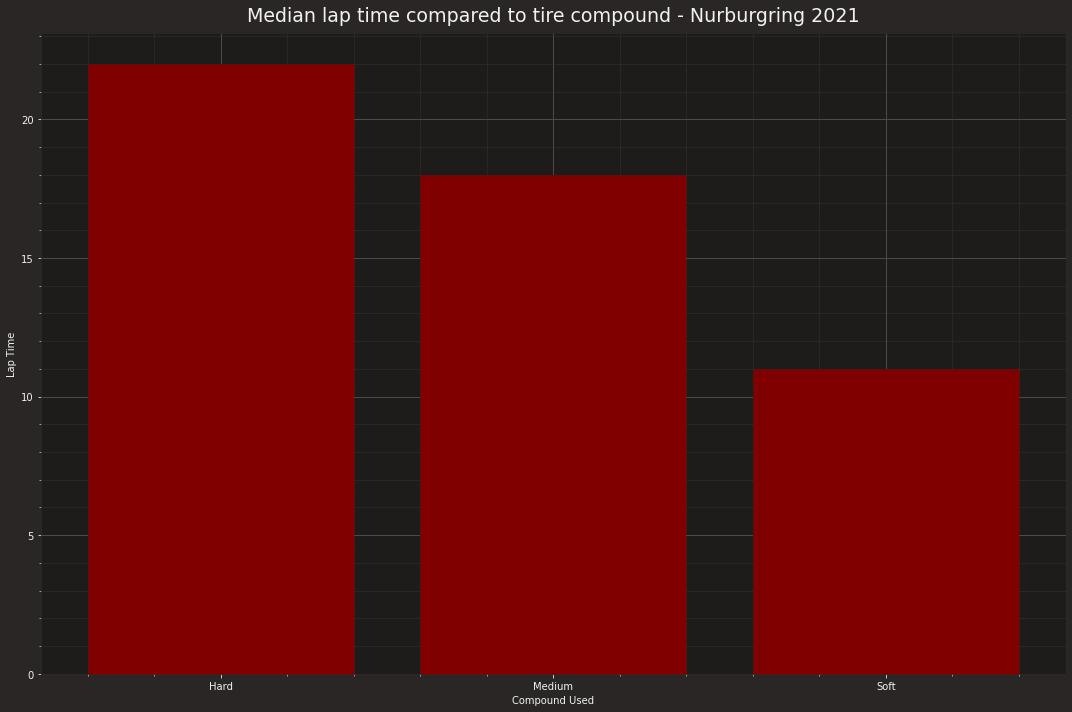

In [10]:
dF = pd.DataFrame(driver_stints).reset_index()
dF = dF.rename(columns ={'LapNumber': 'numLaps'})

soft = dF.loc[dF["Compound"] == "SOFT", "LapTime"]
softMean = soft.mean()
softMedian = soft.median()


medium = dF.loc[dF["Compound"] == "MEDIUM", "LapTime"]
mediumMean = medium.mean()
mediumMedian = medium.median()


hard = dF.loc[dF["Compound"] == "HARD", "LapTime"]
hardMean = hard.mean()
hardMedian = hard.median()


times = {"Hard":hardMedian, "Medium":mediumMedian, "Soft":softMedian}
x = times.keys()
y = times.values()


# Graph Creation
fig, ax = plt.subplots()

plt.bar(x, y, color = 'maroon')

plt.xlabel("Compound Used")
plt.ylabel("Lap Time")
plt.title(f"Median lap time compared to tire compound - {circut} {year}")

Text(0.5, 1.0, 'Average lap time compared to tire compound - Nurburgring 2021')

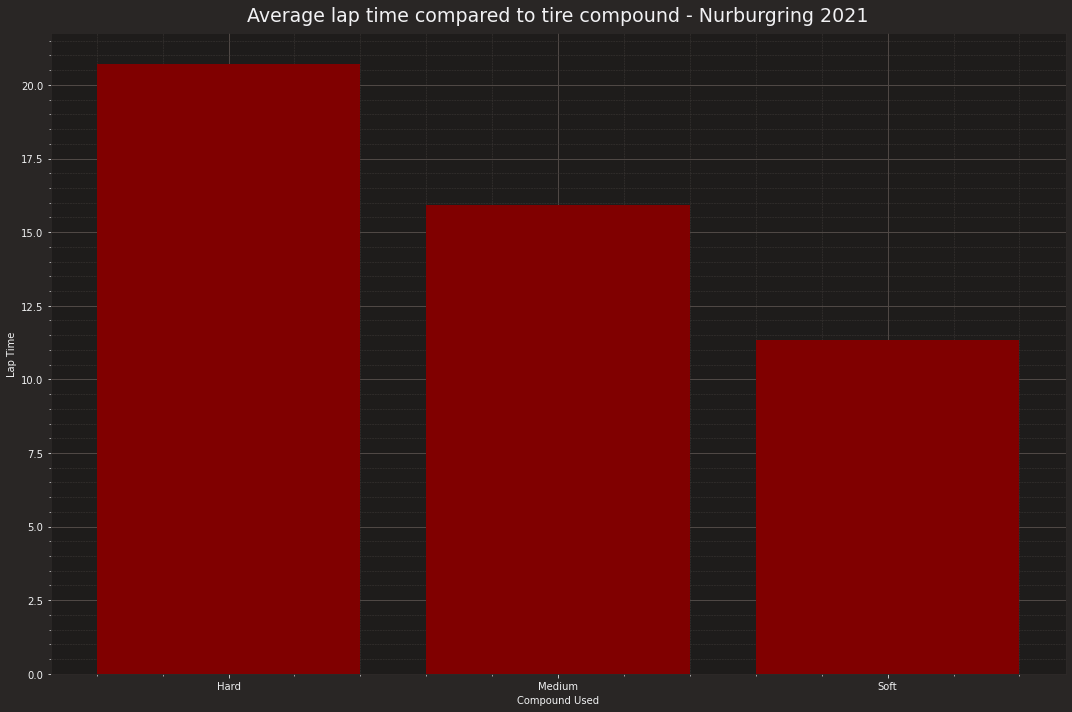

In [11]:
times = {"Hard":hardMean, "Medium":mediumMean, "Soft":softMean}
x = times.keys()
y = times.values()

fig, ax = plt.subplots()

plt.bar(x, y, color = 'maroon')

plt.xlabel("Compound Used")
plt.ylabel("Lap Time")
plt.title(f"Average lap time compared to tire compound - {circut} {year}")

In [12]:
def percentChange(a, b):
    return round(((a-b) / a) * 100, 1)
decreases = []
Mean1 = percentChange(hardMean, mediumMean)
decreases.append(Mean1)
Mean2 = percentChange(mediumMean, softMean)
decreases.append(Mean2)
Median1 = percentChange(hardMedian, mediumMedian)
decreases.append(Median1)
Median2 = percentChange(mediumMedian, softMedian)
decreases.append(Median2)
averageDecrease = sum(decreases) / len(decreases)
averageDecrease

27.275

### Conclusion
Lap time was used to determine how fast a driver was on a particular tire compound. The frist bar chart shows the median lap times on each tire compound. There is a a clear trend that favors softer tires. This same trend is also visible in the seccond bar chart. As the tire gets softer the lap time decreases. Switching to the next softest compound results in a 27% decrease in lap time.

In the prior question (compound use as the race goes on), it would now seem that at the begining of the race is the perfered time to use soft tires. This could be to solifify their position early on in the race. As the race progresses, teams seem to switch to harder compounds. This could be because longevity becomes more important. 
